In [2]:
from IPython.display import display, HTML
display(HTML("""
<style>
.jp-InputArea, .jp-Cell-inputWrapper { display: none !important; }
</style>
"""))

In [3]:
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter
from datetime import datetime
import gc
from typing import Iterator
import warnings

warnings.filterwarnings('ignore')

# Configurações de visualização
sns.set_theme(style="whitegrid", palette="husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

In [4]:
from diario_crawler.storage.parquet_loader import ParquetLoader

# Inicializar loader
loader = ParquetLoader(base_path="../data/raw")


In [5]:
def extract_metadata_batch(
    edition_iterator: Iterator,
    batch_size: int = 100
) -> pl.DataFrame:
    """
    Extrai metadados em batches para controle de memória.
    
    Args:
        edition_iterator: Iterador de edições
        batch_size: Número de edições a processar por vez
    
    Returns:
        DataFrame Polars com metadados consolidados
    """
    editions_data = []
    articles_data = []
    
    batch_count = 0
    
    for i, edition in enumerate(edition_iterator, 1):
        # Metadados da edição
        editions_data.append({
            'edition_id': edition.metadata.edition_id,
            'publication_date': edition.metadata.publication_date,
            'edition_number': edition.metadata.edition_number,
            'supplement': edition.metadata.supplement,
            'edition_type_id': edition.metadata.edition_type_id,
            'edition_type_name': edition.metadata.edition_type_name,
            'pdf_url': edition.metadata.pdf_url,
            'num_articles': len(edition.articles)
        })
        
        # Metadados dos artigos (sem conteúdo)
        for article in edition.articles:
            articles_data.append({
                'article_id': article.metadata.article_id,
                'edition_id': article.metadata.edition_id,
                'hierarchy_path': '|'.join(article.metadata.hierarchy_path),
                'hierarchy_depth': article.metadata.depth,
                'title': article.metadata.title,
                'identifier': article.metadata.identifier,
                'protocol': article.metadata.protocol,
                'content_type': article.content.content_type.value,
                'content_size_bytes': len(article.content.raw_content)
            })
        
        # Processar em batches
        if i % batch_size == 0:
            batch_count += 1
            print(f"✓ Processadas {i} edições ({len(articles_data)} artigos)")
            gc.collect()  # Liberar memória
    
    print(f"\n✓ Total: {len(editions_data)} edições, {len(articles_data)} artigos")
    
    # Converter para DataFrames Polars
    df_editions = pl.DataFrame(editions_data)
    df_articles = pl.DataFrame(articles_data)
    
    return df_editions, df_articles

In [6]:
# Extrair metadados do período completo
print("Iniciando extração de metadados...")
print("=" * 60)

edition_iterator = loader.iter_editions(
    start_date="2022-01-01",
    end_date="2026-01-01"
)

df_editions, df_articles = extract_metadata_batch(edition_iterator, batch_size=50)

print("\n✓ Extração concluída!")

Iniciando extração de metadados...
✓ Processadas 50 edições (486 artigos)
✓ Processadas 100 edições (1040 artigos)
✓ Processadas 150 edições (1598 artigos)
✓ Processadas 200 edições (2207 artigos)
✓ Processadas 250 edições (2754 artigos)
✓ Processadas 300 edições (3386 artigos)
✓ Processadas 350 edições (3991 artigos)
✓ Processadas 400 edições (4656 artigos)
✓ Processadas 450 edições (5339 artigos)
✓ Processadas 500 edições (5998 artigos)

✓ Total: 540 edições, 6501 artigos

✓ Extração concluída!


In [7]:
print("RESUMO DAS EDIÇÕES")
print("=" * 60)
print(f"Total de edições: {df_editions.height:,}")
print(f"Período: {df_editions['publication_date'].min()} a {df_editions['publication_date'].max()}")
print(f"\nEdições suplementares: {df_editions['supplement'].sum():,} ({df_editions['supplement'].mean()*100:.1f}%)")
print(f"Total de artigos: {df_articles.height:,}")
print(f"Média de artigos por edição: {df_editions['num_articles'].mean():.1f}")

RESUMO DAS EDIÇÕES
Total de edições: 540
Período: 2022-08-15 a 2025-11-05

Edições suplementares: 0 (0.0%)
Total de artigos: 6,501
Média de artigos por edição: 12.0


In [8]:
# Adicionar features temporais
df_editions = df_editions.with_columns([
    pl.col('publication_date').str.to_date().alias('date'),
]).with_columns([
    pl.col('date').dt.year().alias('year'),
    pl.col('date').dt.month().alias('month'),
    pl.col('date').dt.weekday().alias('weekday'),
    pl.col('date').dt.quarter().alias('quarter')
])

In [9]:
# Estatísticas por tipo de edição
print("\nESTATÍSTICAS POR TIPO DE EDIÇÃO")
print("=" * 60)
stats_by_type = (
    df_editions
    .group_by('edition_type_name')
    .agg([
        pl.len().alias('count'),
        pl.col('num_articles').mean().alias('avg_articles'),
        pl.col('num_articles').sum().alias('total_articles')
    ])
    .sort('count', descending=True)
)
print(stats_by_type)



ESTATÍSTICAS POR TIPO DE EDIÇÃO
shape: (1, 4)
┌─────────────────────┬───────┬──────────────┬────────────────┐
│ edition_type_name   ┆ count ┆ avg_articles ┆ total_articles │
│ ---                 ┆ ---   ┆ ---          ┆ ---            │
│ str                 ┆ u32   ┆ f64          ┆ i64            │
╞═════════════════════╪═══════╪══════════════╪════════════════╡
│ Diário do Município ┆ 540   ┆ 12.038889    ┆ 6501           │
└─────────────────────┴───────┴──────────────┴────────────────┘


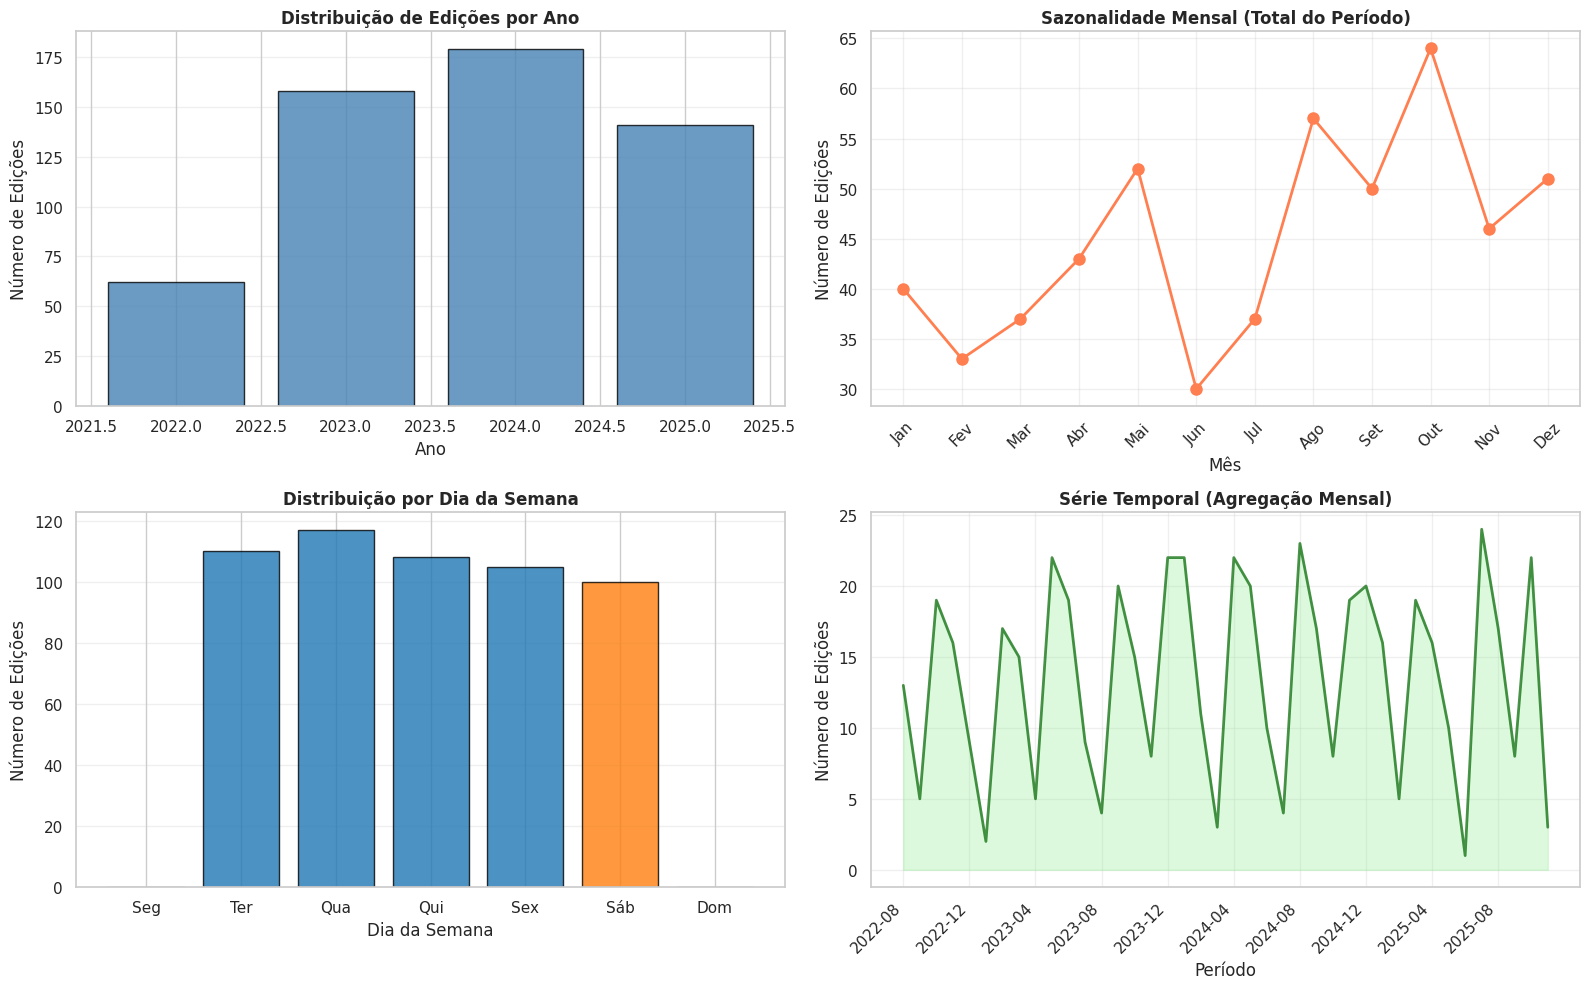

In [10]:
# Visualização: Distribuição de edições ao longo do tempo
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Edições por ano
editions_by_year = (
    df_editions
    .group_by('year')
    .agg(pl.len().alias('count'))
    .sort('year')
)
ax1 = axes[0, 0]
ax1.bar(editions_by_year['year'].to_list(), editions_by_year['count'].to_list(), 
        color='steelblue', alpha=0.8, edgecolor='black')
ax1.set_xlabel('Ano')
ax1.set_ylabel('Número de Edições')
ax1.set_title('Distribuição de Edições por Ano', fontweight='bold', fontsize=12)
ax1.grid(axis='y', alpha=0.3)

# 2. Edições por mês (agregado)
editions_by_month = (
    df_editions
    .group_by('month')
    .agg(pl.len().alias('count'))
    .sort('month')
)
ax2 = axes[0, 1]
months = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']
ax2.plot(editions_by_month['month'].to_list(), editions_by_month['count'].to_list(), 
         marker='o', linewidth=2, markersize=8, color='coral')
ax2.set_xlabel('Mês')
ax2.set_ylabel('Número de Edições')
ax2.set_title('Sazonalidade Mensal (Total do Período)', fontweight='bold', fontsize=12)
ax2.set_xticks(range(1, 13))
ax2.set_xticklabels(months, rotation=45)
ax2.grid(alpha=0.3)

# 3. Edições por dia da semana
editions_by_weekday = (
    df_editions
    .group_by('weekday')
    .agg(pl.len().alias('count'))
    .sort('weekday')
)
ax3 = axes[1, 0]
weekdays = ['Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sáb', 'Dom']
# Criar lista completa com zeros para dias ausentes
weekday_counts = [0] * 7
for row in editions_by_weekday.iter_rows(named=True):
    weekday_counts[row['weekday']] = row['count']
colors_weekday = ['#1f77b4' if i < 5 else '#ff7f0e' for i in range(7)]
ax3.bar(weekdays, weekday_counts, 
        color=colors_weekday, alpha=0.8, edgecolor='black')
ax3.set_xlabel('Dia da Semana')
ax3.set_ylabel('Número de Edições')
ax3.set_title('Distribuição por Dia da Semana', fontweight='bold', fontsize=12)
ax3.grid(axis='y', alpha=0.3)

# 4. Evolução temporal (série temporal mensal)
df_monthly = (
    df_editions
    .group_by(['year', 'month'])
    .agg(pl.len().alias('count'))
    .sort(['year', 'month'])
    .with_columns([
        (pl.col('year').cast(pl.Utf8) + '-' + pl.col('month').cast(pl.Utf8).str.zfill(2)).alias('year_month')
    ])
)
ax4 = axes[1, 1]
ax4.plot(range(len(df_monthly)), df_monthly['count'].to_list(), 
         linewidth=2, color='darkgreen', alpha=0.7)
ax4.fill_between(range(len(df_monthly)), df_monthly['count'].to_list(), 
                  alpha=0.3, color='lightgreen')
ax4.set_xlabel('Período')
ax4.set_ylabel('Número de Edições')
ax4.set_title('Série Temporal (Agregação Mensal)', fontweight='bold', fontsize=12)
ax4.grid(alpha=0.3)
# Mostrar apenas alguns rótulos no eixo x
step = max(1, len(df_monthly) // 10)
ax4.set_xticks(range(0, len(df_monthly), step))
ax4.set_xticklabels(df_monthly['year_month'].to_list()[::step], rotation=45, ha='right')

plt.tight_layout()
plt.show()


In [11]:
print("\nRESUMO DOS ARTIGOS")
print("=" * 60)
print(f"Total de artigos: {df_articles.height:,}")
print(f"Profundidade média da hierarquia: {df_articles['hierarchy_depth'].mean():.2f}")
print(f"Tamanho médio do conteúdo: {df_articles['content_size_bytes'].mean()/1024:.1f} KB")
print(f"Tamanho total dos conteúdos: {df_articles['content_size_bytes'].sum()/1024/1024/1024:.2f} GB")


RESUMO DOS ARTIGOS
Total de artigos: 6,501
Profundidade média da hierarquia: 1.65
Tamanho médio do conteúdo: 170.9 KB
Tamanho total dos conteúdos: 1.06 GB


In [12]:
# Estatísticas por tipo de conteúdo
print("\nESTATÍSTICAS POR TIPO DE CONTEÚDO")
print("=" * 60)
stats_by_content = (
    df_articles
    .group_by('content_type')
    .agg([
        pl.len().alias('count'),
        pl.col('content_size_bytes').mean().alias('avg_size_kb'),
        pl.col('content_size_bytes').sum().alias('total_size_gb')
    ])
    .with_columns([
        (pl.col('avg_size_kb') / 1024).round(2),
        (pl.col('total_size_gb') / 1024 / 1024 / 1024).round(3)
    ])
    .sort('count', descending=True)
)
print(stats_by_content)


ESTATÍSTICAS POR TIPO DE CONTEÚDO
shape: (2, 4)
┌──────────────┬───────┬─────────────┬───────────────┐
│ content_type ┆ count ┆ avg_size_kb ┆ total_size_gb │
│ ---          ┆ ---   ┆ ---         ┆ ---           │
│ str          ┆ u32   ┆ f64         ┆ f64           │
╞══════════════╪═══════╪═════════════╪═══════════════╡
│ html         ┆ 5521  ┆ 38.8        ┆ 0.204         │
│ pdf          ┆ 980   ┆ 914.79      ┆ 0.855         │
└──────────────┴───────┴─────────────┴───────────────┘


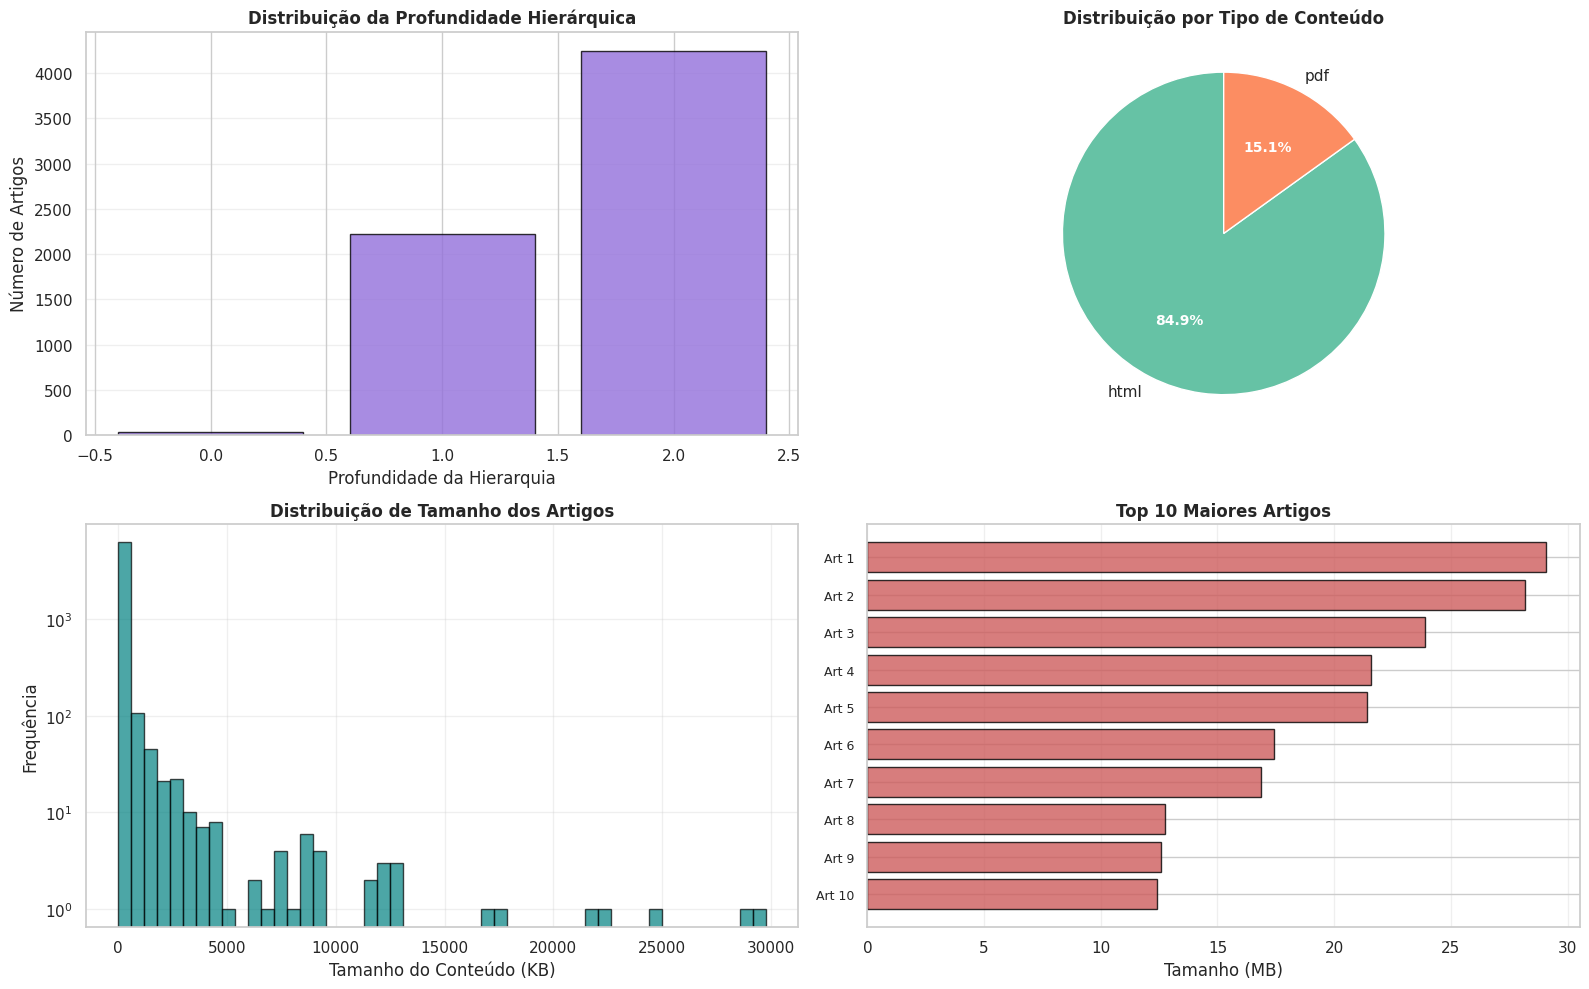

In [13]:
# Visualizações de artigos
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Distribuição de profundidade hierárquica
ax1 = axes[0, 0]
depth_counts = df_articles['hierarchy_depth'].value_counts().sort('hierarchy_depth')
ax1.bar(depth_counts['hierarchy_depth'].to_list(), depth_counts['count'].to_list(),
        color='mediumpurple', alpha=0.8, edgecolor='black')
ax1.set_xlabel('Profundidade da Hierarquia')
ax1.set_ylabel('Número de Artigos')
ax1.set_title('Distribuição da Profundidade Hierárquica', fontweight='bold', fontsize=12)
ax1.grid(axis='y', alpha=0.3)

# 2. Tipos de conteúdo
ax2 = axes[0, 1]
content_counts = df_articles['content_type'].value_counts()
colors_pie = sns.color_palette('Set2', len(content_counts))
wedges, texts, autotexts = ax2.pie(content_counts['count'].to_list(), 
                                     labels=content_counts['content_type'].to_list(),
                                     autopct='%1.1f%%', startangle=90, colors=colors_pie)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
ax2.set_title('Distribuição por Tipo de Conteúdo', fontweight='bold', fontsize=12)

# 3. Distribuição de tamanho dos artigos (log scale)
ax3 = axes[1, 0]
sizes_kb = (df_articles['content_size_bytes'] / 1024).to_list()
ax3.hist(sizes_kb, bins=50, color='teal', alpha=0.7, edgecolor='black')
ax3.set_xlabel('Tamanho do Conteúdo (KB)')
ax3.set_ylabel('Frequência')
ax3.set_title('Distribuição de Tamanho dos Artigos', fontweight='bold', fontsize=12)
ax3.set_yscale('log')
ax3.grid(alpha=0.3)

# 4. Top 10 maiores artigos
ax4 = axes[1, 1]
top_sizes = (
    df_articles
    .select(['article_id', 'content_size_bytes', 'title'])
    .sort('content_size_bytes', descending=True)
    .head(10)
    .with_columns((pl.col('content_size_bytes') / 1024 / 1024).alias('size_mb'))
)
y_pos = range(len(top_sizes))
ax4.barh(y_pos, top_sizes['size_mb'].to_list(), color='indianred', alpha=0.8, edgecolor='black')
ax4.set_yticks(y_pos)
ax4.set_yticklabels([f"Art {i+1}" for i in y_pos], fontsize=9)
ax4.set_xlabel('Tamanho (MB)')
ax4.set_title('Top 10 Maiores Artigos', fontweight='bold', fontsize=12)
ax4.invert_yaxis()
ax4.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

In [14]:
print("\nANÁLISE DE CAMINHOS HIERÁRQUICOS")
print("=" * 60)

# Extrair todos os caminhos e contar
all_paths = df_articles['hierarchy_path'].to_list()
path_counter = Counter(all_paths)

print(f"Total de caminhos únicos: {len(path_counter):,}")
print(f"\nTop 20 caminhos mais comuns:")
print("-" * 60)

top_20_paths = path_counter.most_common(20)
for i, (path, count) in enumerate(top_20_paths, 1):
    pct = (count / len(all_paths)) * 100
    # Truncar path se muito longo
    display_path = path if len(path) < 80 else path[:77] + "..."
    print(f"{i:2d}. [{count:6,} artigos, {pct:5.2f}%] {display_path}")


ANÁLISE DE CAMINHOS HIERÁRQUICOS
Total de caminhos únicos: 72

Top 20 caminhos mais comuns:
------------------------------------------------------------
 1. [   465 artigos,  7.15%] Decretos
 2. [   429 artigos,  6.60%] IPSM
 3. [   379 artigos,  5.83%] Fundhas
 4. [   374 artigos,  5.75%] Anexos|Secretaria de Gestão Administrativa e Finanças
 5. [   356 artigos,  5.48%] Fundação Cultural
 6. [   339 artigos,  5.21%] Portarias|Secretaria de Governança
 7. [   337 artigos,  5.18%] Contratos|Secretaria de Apoio Jurídico
 8. [   321 artigos,  4.94%] Editais|Secretaria de Gestão Administrativa e Finanças
 9. [   320 artigos,  4.92%] Licitações|Secretaria de Gestão Administrativa e Finanças
10. [   298 artigos,  4.58%] Licitações|Secretaria de Saúde
11. [   297 artigos,  4.57%] Educação
12. [   291 artigos,  4.48%] Portarias|Secretaria de Gestão Administrativa e Finanças
13. [   230 artigos,  3.54%] Outros|Secretaria de Apoio Social ao Cidadão
14. [   204 artigos,  3.14%] Outros|Secretaria

In [47]:
# Análise de elementos individuais da hierarquia
print("\n\nANÁLISE DE ELEMENTOS HIERÁRQUICOS")
print("=" * 60)

# Extrair cada nível da hierarquia
hierarchy_elements = []
for i, path in enumerate(all_paths):
    elements = path.split('|')
    for level, elem in enumerate(elements):
        hierarchy_elements.append({
            'path_id': i,  # 🔥 unique identifier for this hierarchy
            'level': level,
            'element': elem,
            'depth': len(elements)
        })

df_hierarchy = pl.DataFrame(hierarchy_elements)


# Elementos mais comuns por nível
for level in range(5):  # Analisar até 5 níveis
    level_data = df_hierarchy.filter(pl.col('level') == level)
    if level_data.height == 0:
        break
    
    print(f"\n--- NÍVEL {level} ---")
    top_elements = (
        level_data
        .group_by('element')
        .agg(pl.len().alias('count'))
        .sort('count', descending=True)
        .head(10)
    )
    for row in top_elements.iter_rows(named=True):
        pct = (row['count'] / level_data.height) * 100
        print(f"  {row['element'][:60]:60s} : {row['count']:6,} ({pct:5.1f}%)")



ANÁLISE DE ELEMENTOS HIERÁRQUICOS

--- NÍVEL 0 ---
  Outros                                                       :  1,041 ( 16.0%)
  Portarias                                                    :    868 ( 13.4%)
  Editais                                                      :    851 ( 13.1%)
  Licitações                                                   :    618 (  9.5%)
  Anexos                                                       :    552 (  8.5%)
  Decretos                                                     :    465 (  7.2%)
  IPSM                                                         :    429 (  6.6%)
  Fundhas                                                      :    379 (  5.8%)
  Fundação Cultural                                            :    356 (  5.5%)
  Contratos                                                    :    337 (  5.2%)

--- NÍVEL 1 ---
  Secretaria de Gestão Administrativa e Finanças               :  1,510 ( 35.6%)
  Secretaria de Governança             

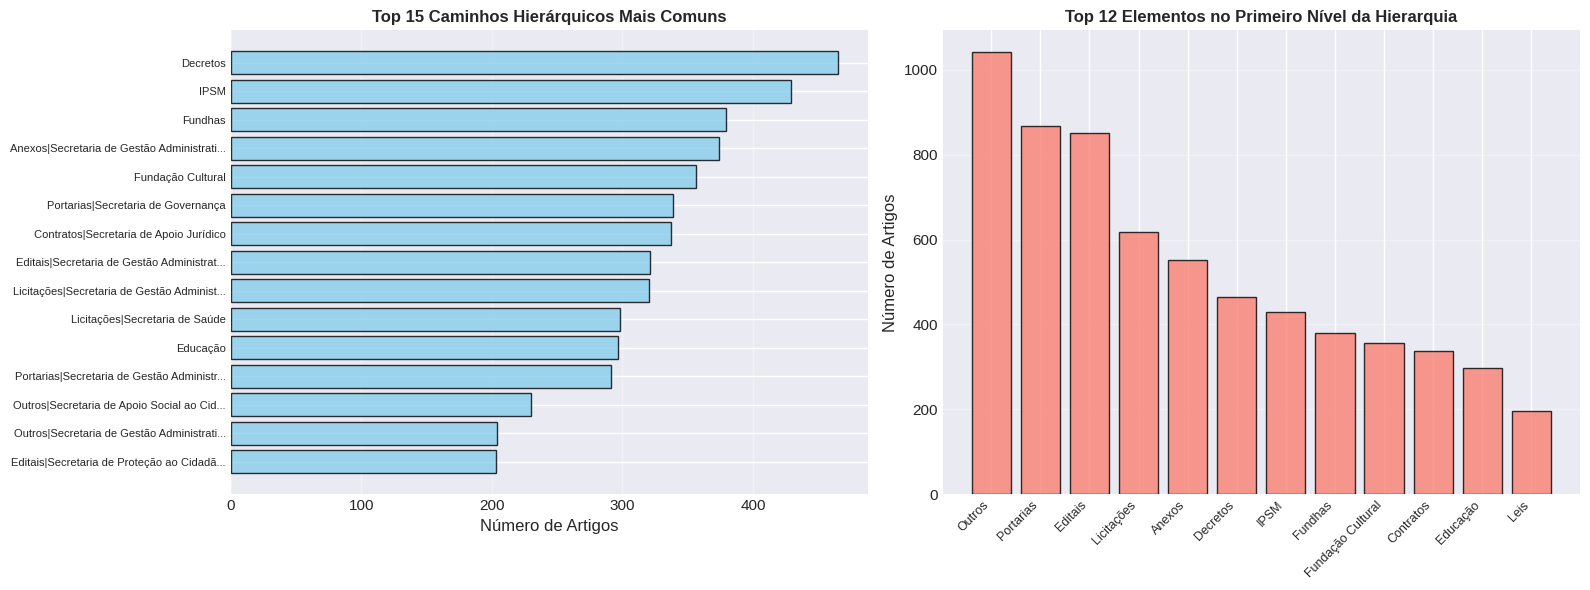

In [48]:
# Visualização da hierarquia
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Top 15 caminhos mais comuns
ax1 = axes[0]
top_15 = sorted(path_counter.most_common(15), key=lambda x: x[1])
paths_display = [p[:40] + '...' if len(p) > 40 else p for p, _ in top_15]
counts = [c for _, c in top_15]

y_pos = range(len(top_15))
ax1.barh(y_pos, counts, color='skyblue', alpha=0.8, edgecolor='black')
ax1.set_yticks(y_pos)
ax1.set_yticklabels(paths_display, fontsize=8)
ax1.set_xlabel('Número de Artigos')
ax1.set_title('Top 15 Caminhos Hierárquicos Mais Comuns', fontweight='bold', fontsize=12)
ax1.grid(axis='x', alpha=0.3)

# 2. Distribuição de elementos no primeiro nível
ax2 = axes[1]
level_0 = (
    df_hierarchy
    .filter(pl.col('level') == 0)
    .group_by('element')
    .agg(pl.len().alias('count'))
    .sort('count', descending=True)
    .head(12)
)
ax2.bar(range(len(level_0)), level_0['count'].to_list(), 
        color='salmon', alpha=0.8, edgecolor='black')
ax2.set_xticks(range(len(level_0)))
ax2.set_xticklabels([e[:20] for e in level_0['element'].to_list()], 
                      rotation=45, ha='right', fontsize=9)
ax2.set_ylabel('Número de Artigos')
ax2.set_title('Top 12 Elementos no Primeiro Nível da Hierarquia', fontweight='bold', fontsize=12)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

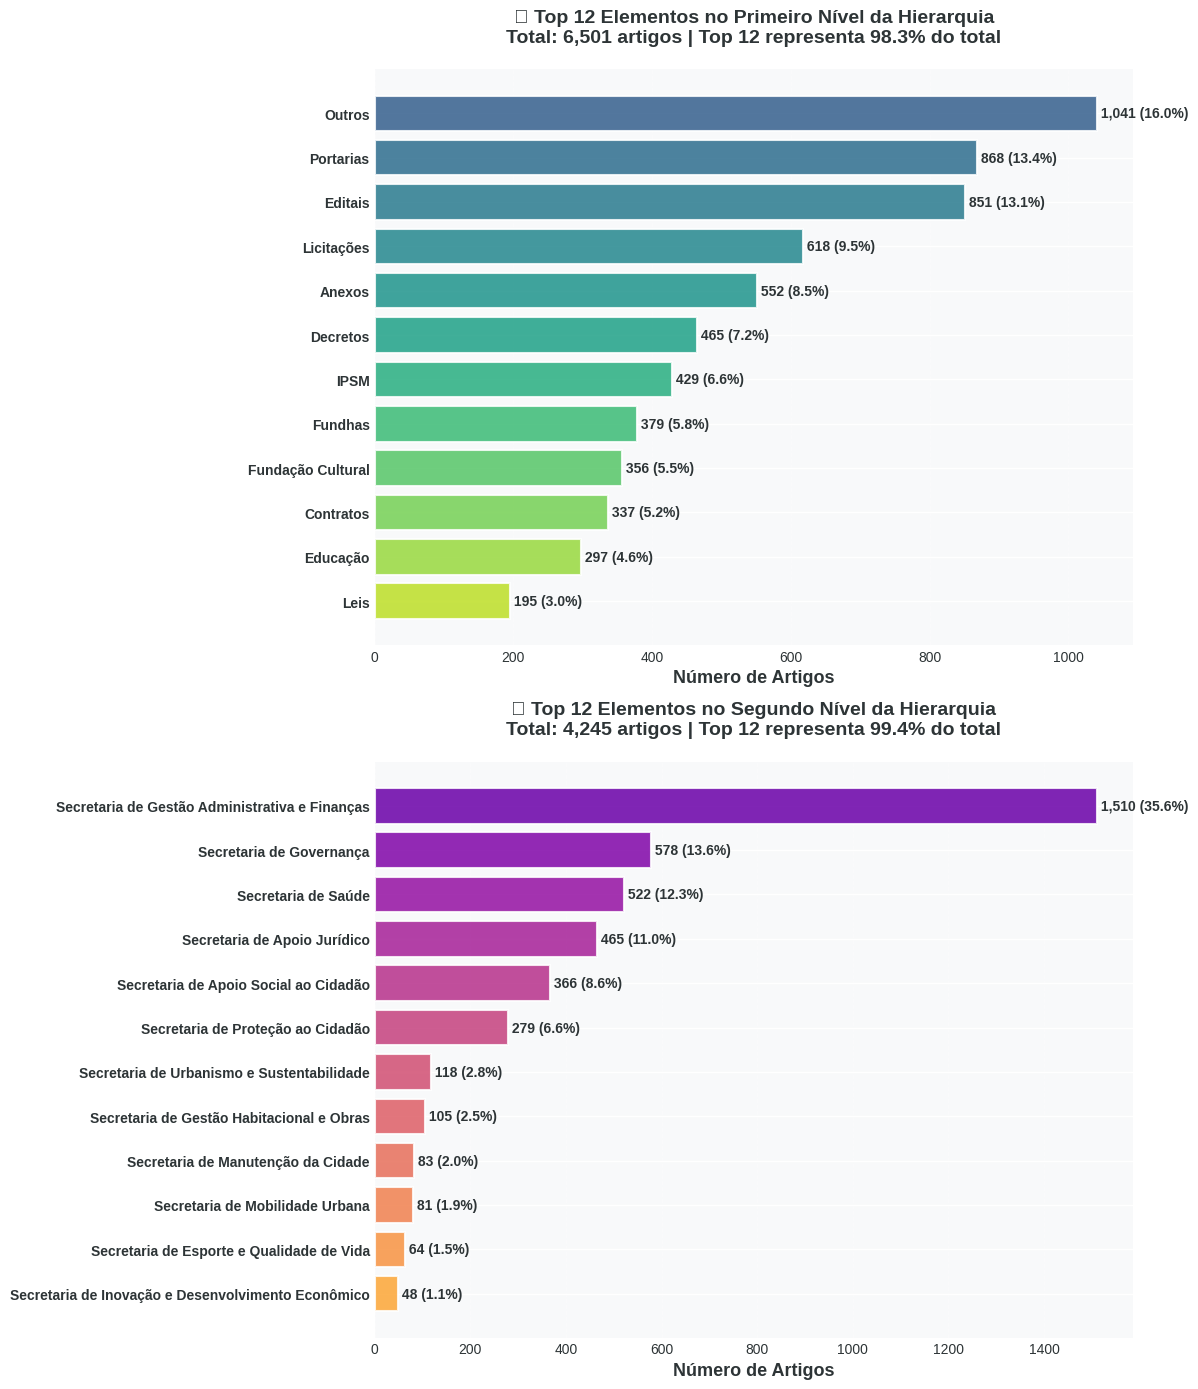

In [49]:
import matplotlib.pyplot as plt
import numpy as np

# Configurar estilo moderno
plt.style.use('seaborn-v0_8-darkgrid')
fig, axes = plt.subplots(2, 1, figsize=(12, 14))

# Paleta de cores moderna (gradiente azul-roxo)
colors_1 = plt.cm.viridis(np.linspace(0.3, 0.9, 12))
colors_2 = plt.cm.plasma(np.linspace(0.2, 0.8, 12))

# ============= Gráfico 1: Nível 0 =============
ax1 = axes[0]
level_0 = (
    df_hierarchy
    .filter(pl.col('level') == 0)
    .group_by('element')
    .agg(pl.len().alias('count'))
    .sort('count', descending=True)
    .head(12)
)

# Calcular total e percentuais
total_0 = df_hierarchy.filter(pl.col('level') == 0).height
counts_0 = level_0['count'].to_list()
percentages_0 = [(count / total_0) * 100 for count in counts_0]
cumulative_0 = np.cumsum(percentages_0)

y_pos_1 = np.arange(len(level_0))
bars1 = ax1.barh(y_pos_1, 
                 counts_0,
                 color=colors_1,
                 alpha=0.85,
                 edgecolor='white',
                 linewidth=1.5,
                 zorder=3)

# Adicionar valores e percentuais no final das barras
for i, (bar, value, pct, cum_pct) in enumerate(zip(bars1, counts_0, percentages_0, cumulative_0)):
    width = bar.get_width()
    ax1.text(width, bar.get_y() + bar.get_height()/2.,
             f' {value:,} ({pct:.1f}%)',
             ha='left', va='center',
             fontsize=10, fontweight='bold',
             color='#2d3436')

# Labels no eixo Y com contagem total
elements_0 = level_0['element'].to_list()
ax1.set_yticks(y_pos_1)
ax1.set_yticklabels(elements_0, fontsize=11, fontweight='600')
ax1.set_xlabel('Número de Artigos', fontsize=13, fontweight='bold', color='#2d3436')
ax1.set_title(f'🏆 Top 12 Elementos no Primeiro Nível da Hierarquia\nTotal: {total_0:,} artigos | Top 12 representa {cumulative_0[-1]:.1f}% do total',
              fontweight='bold', fontsize=14, pad=20, color='#2d3436')

# Inverter eixo Y
ax1.invert_yaxis()

# Estilização do grid e fundo
ax1.grid(axis='x', alpha=0.3, linestyle='--', linewidth=0.8, zorder=0)
ax1.set_facecolor('#f8f9fa')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_color('#95a5a6')
ax1.spines['bottom'].set_color('#95a5a6')
ax1.tick_params(colors='#2d3436', labelsize=10)

# ============= Gráfico 2: Nível 1 =============
ax2 = axes[1]
level_1 = (
    df_hierarchy
    .filter(pl.col('level') == 1)
    .group_by('element')
    .agg(pl.len().alias('count'))
    .sort('count', descending=True)
    .head(12)
)

# Calcular total e percentuais
total_1 = df_hierarchy.filter(pl.col('level') == 1).height
counts_1 = level_1['count'].to_list()
percentages_1 = [(count / total_1) * 100 for count in counts_1]
cumulative_1 = np.cumsum(percentages_1)

y_pos_2 = np.arange(len(level_1))
bars2 = ax2.barh(y_pos_2,
                 counts_1,
                 color=colors_2,
                 alpha=0.85,
                 edgecolor='white',
                 linewidth=1.5,
                 zorder=3)

# Adicionar valores e percentuais no final das barras
for i, (bar, value, pct, cum_pct) in enumerate(zip(bars2, counts_1, percentages_1, cumulative_1)):
    width = bar.get_width()
    ax2.text(width, bar.get_y() + bar.get_height()/2.,
             f' {value:,} ({pct:.1f}%)',
             ha='left', va='center',
             fontsize=10, fontweight='bold',
             color='#2d3436')

# Labels no eixo Y
elements_1 = level_1['element'].to_list()
ax2.set_yticks(y_pos_2)
ax2.set_yticklabels(elements_1, fontsize=11, fontweight='600')
ax2.set_xlabel('Número de Artigos', fontsize=13, fontweight='bold', color='#2d3436')
ax2.set_title(f'📊 Top 12 Elementos no Segundo Nível da Hierarquia\nTotal: {total_1:,} artigos | Top 12 representa {cumulative_1[-1]:.1f}% do total',
              fontweight='bold', fontsize=14, pad=20, color='#2d3436')

# Inverter eixo Y
ax2.invert_yaxis()

# Estilização do grid e fundo
ax2.grid(axis='x', alpha=0.3, linestyle='--', linewidth=0.8, zorder=0)
ax2.set_facecolor('#f8f9fa')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_color('#95a5a6')
ax2.spines['bottom'].set_color('#95a5a6')
ax2.tick_params(colors='#2d3436', labelsize=10)

# Ajustes finais
plt.tight_layout()
fig.patch.set_facecolor('white')
plt.show()

In [50]:
df_hierarchy.schema

Schema([('path_id', Int64),
        ('level', Int64),
        ('element', String),
        ('depth', Int64)])

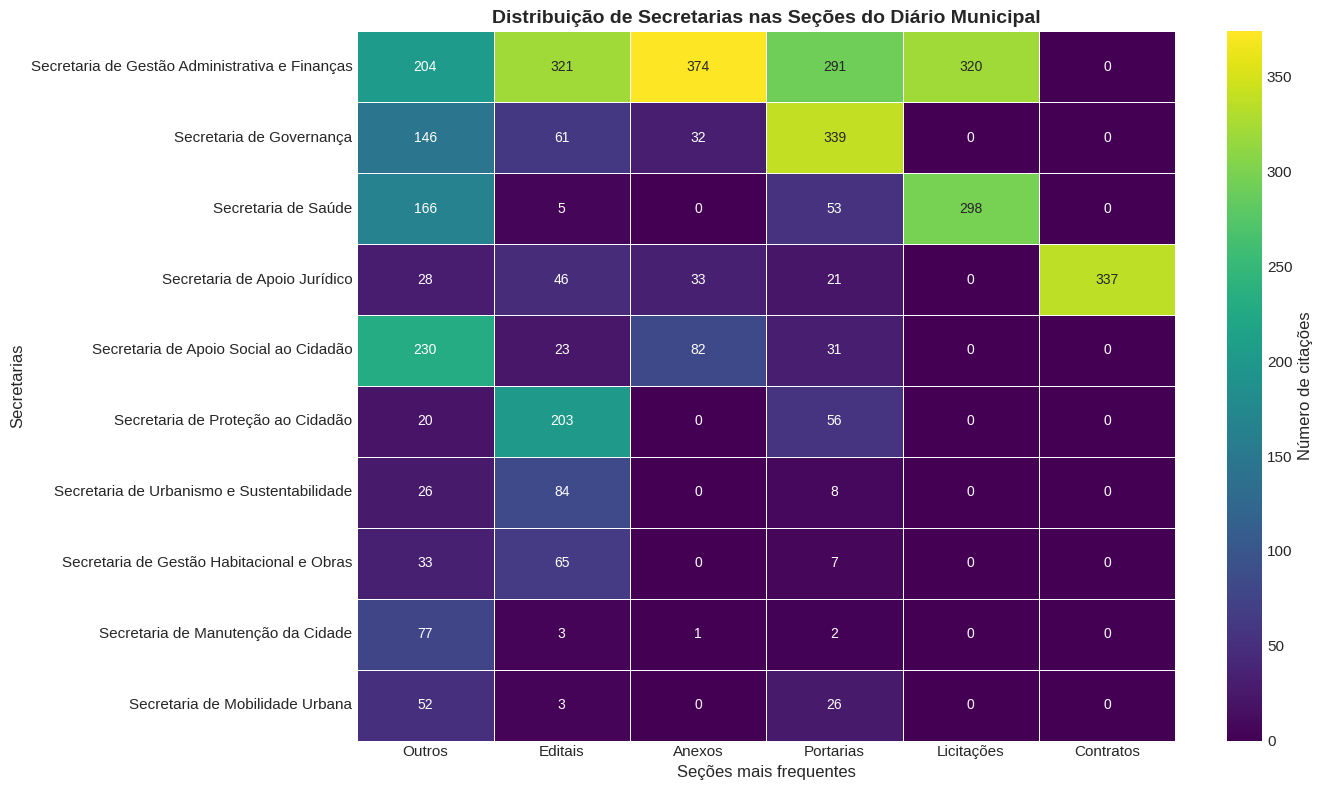

In [69]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================
# 1. Identificar os top 10 level_1
# ==========================
top_level1 = (
    df_hierarchy
    .filter(pl.col('level') == 1)
    .group_by('element')
    .agg(pl.len().alias('count'))
    .sort('count', descending=True)
    .head(10)
)

top_level1_elements = top_level1['element'].to_list()

# ==========================
# 2. Preparar mapeamento entre level_0 e level_1
# ==========================
# Selecionar somente os níveis 0 e 1
df_levels_01 = df_hierarchy.filter(pl.col('level').is_in([0, 1]))

# Criar mapeamento real via path_id (mesmo documento/hierarquia)
# 🔥 É ESSENCIAL que df_hierarchy contenha a coluna 'path_id'
df_pairs = (
    df_levels_01
    .join(
        df_levels_01,
        on="path_id",              # join dentro do mesmo caminho hierárquico
        how="inner",
        suffix="_1"
    )
    .filter((pl.col("level") == 0) & (pl.col("level_1") == 1))
    .select(
        pl.col("element").alias("level_0"),
        pl.col("element_1").alias("level_1")
    )
)

# ==========================
# 3. Contagem das combinações
# ==========================
pair_counts = (
    df_pairs
    .filter(pl.col("level_1").is_in(top_level1_elements))
    .group_by(["level_0", "level_1"])
    .agg(pl.len().alias("count"))
)

# ==========================
# 4. Converter para formato matriz (pivot) com ordem fixa de colunas
# ==========================
heatmap_data = (
    pair_counts
    .pivot(index="level_0", columns="level_1", values="count")
    .fill_null(0)
    .to_pandas()
    .set_index("level_0")
)

# Garantir que todas as colunas dos top 10 existam e estejam na mesma ordem
for col in top_level1_elements:
    if col not in heatmap_data.columns:
        heatmap_data[col] = 0
heatmap_data = heatmap_data[top_level1_elements]
heatmap_data = heatmap_data.transpose()

# ==========================
# 5. Plotar o heatmap
# ==========================
plt.figure(figsize=(14, 8))
sns.heatmap(
    heatmap_data,
    cmap="viridis",
    annot=True,
    fmt=".0f",
    linewidths=0.5,
    cbar_kws={'label': 'Número de citações'}
)

plt.title("Distribuição de Secretarias nas Seções do Diário Municipal", fontsize=14, fontweight='bold')
plt.xlabel("Seções mais frequentes")
plt.ylabel("Secretarias")
plt.tight_layout()
plt.show()



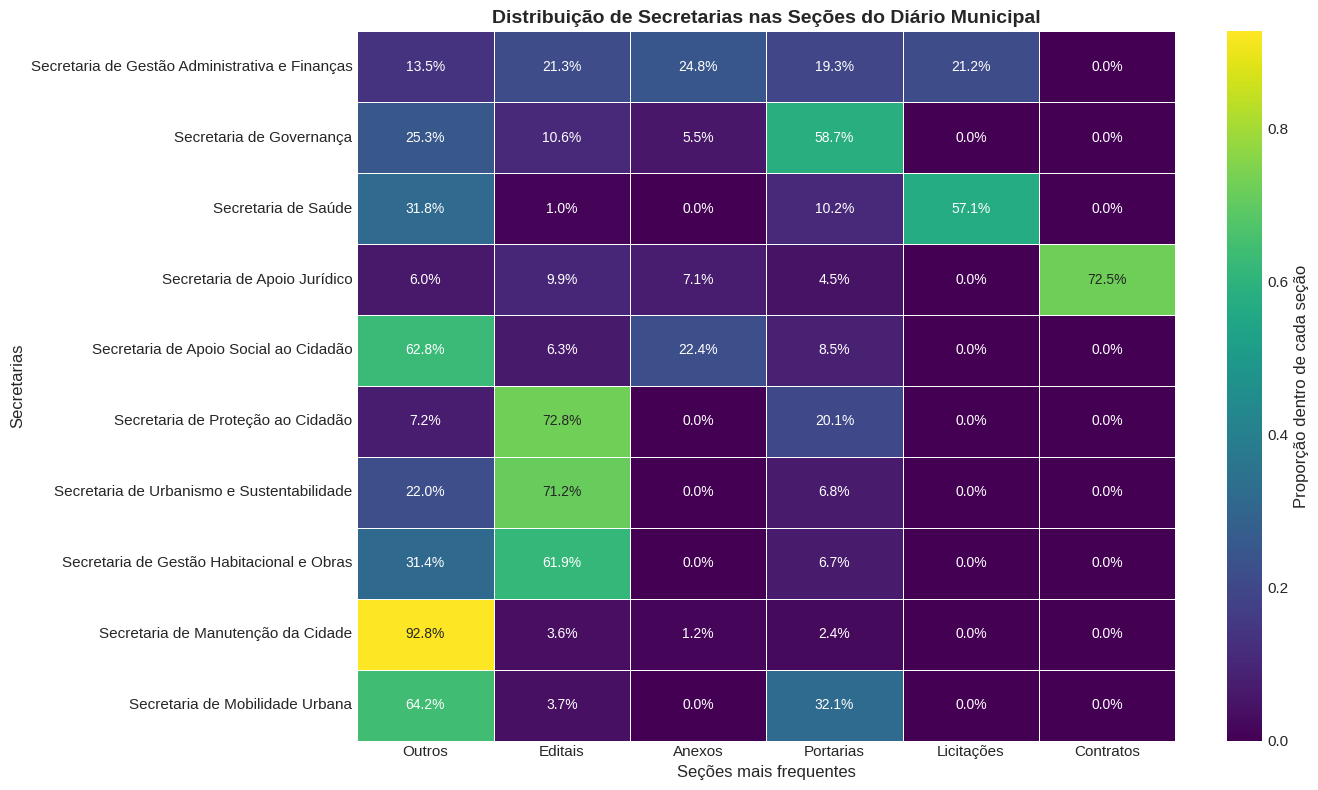

In [71]:
heatmap_data_norm = heatmap_data.div(heatmap_data.sum(axis=1), axis=0)

plt.figure(figsize=(14, 8))
sns.heatmap(
    heatmap_data_norm,
    cmap="viridis",
    annot=True,
    fmt=".1%",
    linewidths=0.5,
    cbar_kws={'label': 'Proporção dentro de cada seção'},
)
plt.title("Distribuição de Secretarias nas Seções do Diário Municipal", fontsize=14, fontweight='bold')
plt.xlabel("Seções mais frequentes")
plt.ylabel("Secretarias")
plt.tight_layout()
plt.show()


In [54]:
# Join para análises combinadas
df_combined = df_articles.join(
    df_editions.select(['edition_id', 'year', 'month', 'edition_type_name', 'supplement']),
    on='edition_id',
    how='left'
)


ANÁLISE TEMPORAL DOS ARTIGOS
shape: (4, 4)
┌──────┬──────────────┬────────────┬───────────────┐
│ year ┆ num_articles ┆ total_size ┆ total_size_gb │
│ ---  ┆ ---          ┆ ---        ┆ ---           │
│ i32  ┆ u32          ┆ i64        ┆ f64           │
╞══════╪══════════════╪════════════╪═══════════════╡
│ 2022 ┆ 623          ┆ 57598736   ┆ 0.053643      │
│ 2023 ┆ 1817         ┆ 280502841  ┆ 0.261239      │
│ 2024 ┆ 2211         ┆ 375439652  ┆ 0.349655      │
│ 2025 ┆ 1850         ┆ 423824306  ┆ 0.394717      │
└──────┴──────────────┴────────────┴───────────────┘


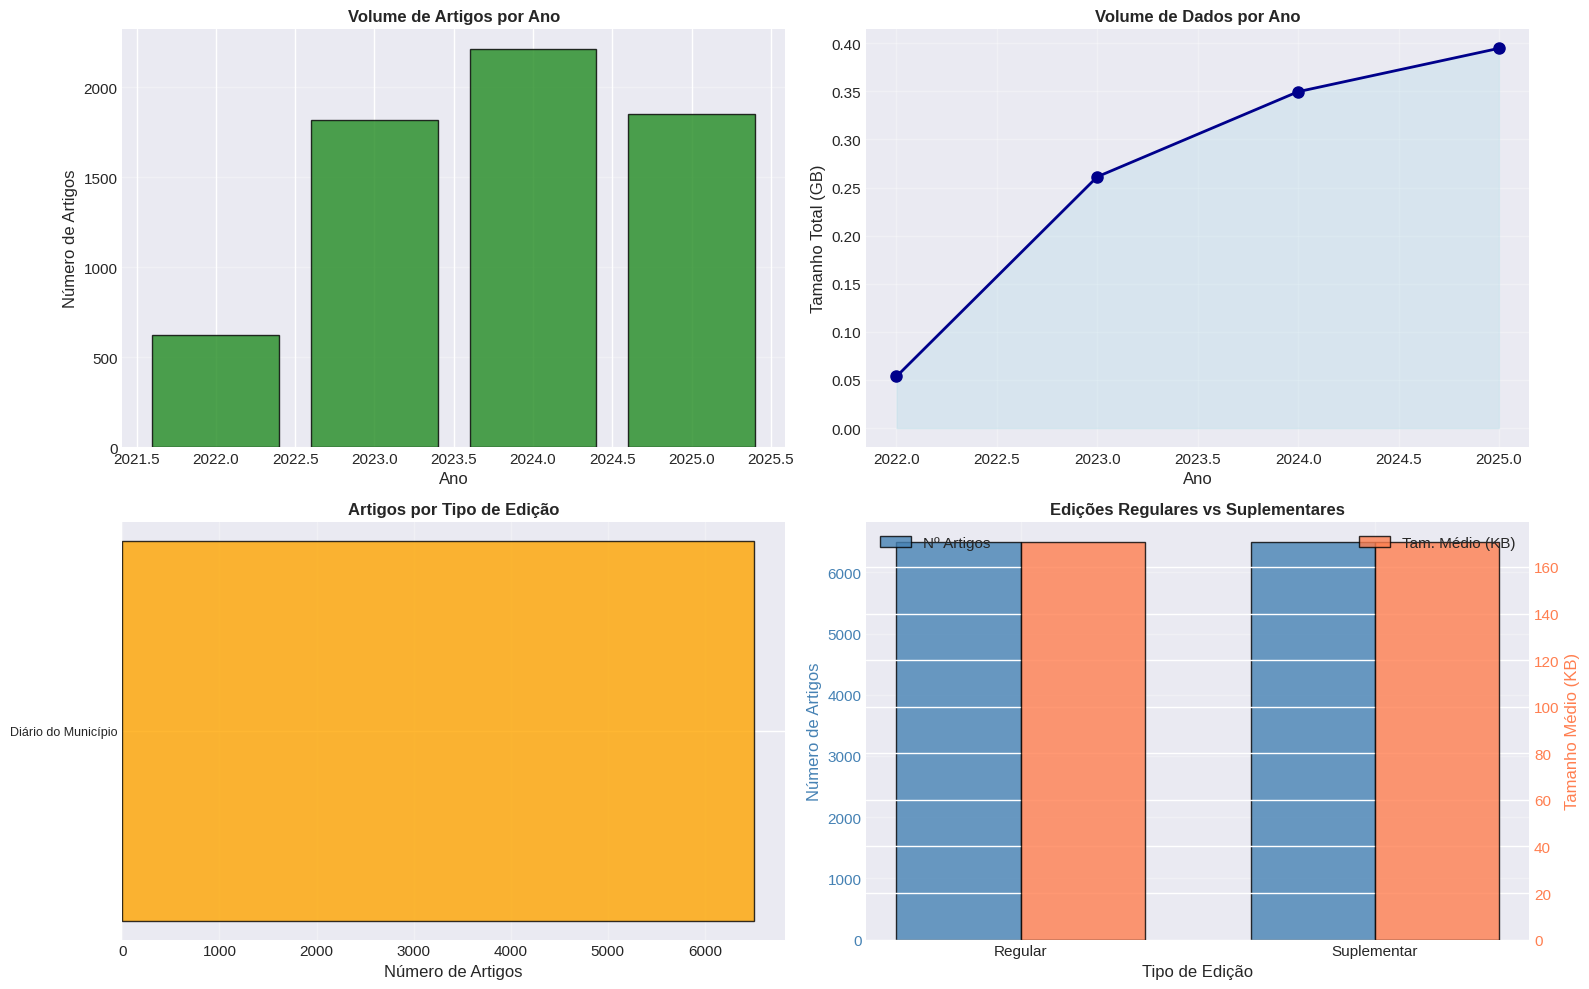

In [55]:
print("\nANÁLISE TEMPORAL DOS ARTIGOS")
print("=" * 60)

articles_by_year = (
    df_combined
    .group_by('year')
    .agg([
        pl.len().alias('num_articles'),
        pl.col('content_size_bytes').sum().alias('total_size')
    ])
    .sort('year')
    .with_columns((pl.col('total_size') / 1024 / 1024 / 1024).alias('total_size_gb'))
)
print(articles_by_year)

# %%
# Visualizações combinadas
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Artigos por ano
ax1 = axes[0, 0]
ax1.bar(articles_by_year['year'].to_list(), articles_by_year['num_articles'].to_list(),
        color='forestgreen', alpha=0.8, edgecolor='black')
ax1.set_xlabel('Ano')
ax1.set_ylabel('Número de Artigos')
ax1.set_title('Volume de Artigos por Ano', fontweight='bold', fontsize=12)
ax1.grid(axis='y', alpha=0.3)

# 2. Tamanho total de dados por ano
ax2 = axes[0, 1]
ax2.plot(articles_by_year['year'].to_list(), articles_by_year['total_size_gb'].to_list(),
         marker='o', linewidth=2, markersize=8, color='darkblue')
ax2.fill_between(articles_by_year['year'].to_list(), articles_by_year['total_size_gb'].to_list(),
                  alpha=0.3, color='lightblue')
ax2.set_xlabel('Ano')
ax2.set_ylabel('Tamanho Total (GB)')
ax2.set_title('Volume de Dados por Ano', fontweight='bold', fontsize=12)
ax2.grid(alpha=0.3)

# 3. Artigos por tipo de edição
ax3 = axes[1, 0]
articles_by_type = (
    df_combined
    .group_by('edition_type_name')
    .agg(pl.len().alias('count'))
    .sort('count', descending=True)
)
ax3.barh(range(len(articles_by_type)), articles_by_type['count'].to_list(),
         color='orange', alpha=0.8, edgecolor='black')
ax3.set_yticks(range(len(articles_by_type)))
ax3.set_yticklabels(articles_by_type['edition_type_name'].to_list(), fontsize=9)
ax3.set_xlabel('Número de Artigos')
ax3.set_title('Artigos por Tipo de Edição', fontweight='bold', fontsize=12)
ax3.invert_yaxis()
ax3.grid(axis='x', alpha=0.3)

# 4. Comparação: Edições suplementares vs regulares
ax4 = axes[1, 1]
supplement_stats = (
    df_combined
    .group_by('supplement')
    .agg([
        pl.len().alias('num_articles'),
        pl.col('content_size_bytes').mean().alias('avg_size_kb')
    ])
    .with_columns((pl.col('avg_size_kb') / 1024).alias('avg_size_kb'))
    .sort('supplement')
)
x = ['Regular', 'Suplementar']
width = 0.35
x_pos = [0, 1]

ax4_twin = ax4.twinx()
bars1 = ax4.bar([p - width/2 for p in x_pos], supplement_stats['num_articles'].to_list(),
                width, label='Nº Artigos', color='steelblue', alpha=0.8, edgecolor='black')
bars2 = ax4_twin.bar([p + width/2 for p in x_pos], supplement_stats['avg_size_kb'].to_list(),
                     width, label='Tam. Médio (KB)', color='coral', alpha=0.8, edgecolor='black')

ax4.set_xlabel('Tipo de Edição')
ax4.set_ylabel('Número de Artigos', color='steelblue')
ax4_twin.set_ylabel('Tamanho Médio (KB)', color='coral')
ax4.set_title('Edições Regulares vs Suplementares', fontweight='bold', fontsize=12)
ax4.set_xticks(x_pos)
ax4.set_xticklabels(x)
ax4.tick_params(axis='y', labelcolor='steelblue')
ax4_twin.tick_params(axis='y', labelcolor='coral')
ax4.legend(loc='upper left')
ax4_twin.legend(loc='upper right')
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [56]:
print("\n" + "="*80)
print("SUMÁRIO EXECUTIVO DA ANÁLISE")
print("="*80)

print(f"\n📊 VOLUME DE DADOS:")
print(f"  • Período analisado: {df_editions['publication_date'].min()} a {df_editions['publication_date'].max()}")
print(f"  • Total de edições: {df_editions.height:,}")
print(f"  • Total de artigos: {df_articles.height:,}")
print(f"  • Volume total de dados: {df_articles['content_size_bytes'].sum()/1024/1024/1024:.2f} GB")

print(f"\n📅 CARACTERÍSTICAS TEMPORAIS:")
print(f"  • Média de edições por ano: {df_editions.height / df_editions['year'].n_unique():.0f}")
print(f"  • Média de artigos por edição: {df_editions['num_articles'].mean():.1f}")
print(f"  • Dia da semana mais comum: {weekdays[editions_by_weekday['count'].arg_max()]}")

print(f"\n📄 CARACTERÍSTICAS DOS ARTIGOS:")
print(f"  • Profundidade hierárquica média: {df_articles['hierarchy_depth'].mean():.2f} níveis")
print(f"  • Tamanho médio do artigo: {df_articles['content_size_bytes'].mean()/1024:.1f} KB")
print(f"  • Tipo de conteúdo predominante: {stats_by_content['content_type'][0]}")
print(f"  • Caminhos hierárquicos únicos: {len(path_counter):,}")

print(f"\n🏷️ TOP 3 CAMINHOS HIERÁRQUICOS:")
for i, (path, count) in enumerate(top_20_paths[:3], 1):
    pct = (count / len(all_paths)) * 100
    display = path if len(path) < 70 else path[:67] + "..."
    print(f"  {i}. {display}")
    print(f"     └─ {count:,} artigos ({pct:.1f}%)")

print("\n" + "="*80)
print("✓ Análise concluída com sucesso!")
print("="*80)


SUMÁRIO EXECUTIVO DA ANÁLISE

📊 VOLUME DE DADOS:
  • Período analisado: 2022-08-15 a 2025-11-05
  • Total de edições: 540
  • Total de artigos: 6,501
  • Volume total de dados: 1.06 GB

📅 CARACTERÍSTICAS TEMPORAIS:
  • Média de edições por ano: 135
  • Média de artigos por edição: 12.0
  • Dia da semana mais comum: Ter

📄 CARACTERÍSTICAS DOS ARTIGOS:
  • Profundidade hierárquica média: 1.65 níveis
  • Tamanho médio do artigo: 170.9 KB
  • Tipo de conteúdo predominante: html
  • Caminhos hierárquicos únicos: 72

🏷️ TOP 3 CAMINHOS HIERÁRQUICOS:
  1. Decretos
     └─ 465 artigos (7.2%)
  2. IPSM
     └─ 429 artigos (6.6%)
  3. Fundhas
     └─ 379 artigos (5.8%)

✓ Análise concluída com sucesso!
